<a href="https://www.kaggle.com/code/thomasyow/video-shares-impact-on-video-longevity-wip?scriptVersionId=208931701" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/200k-youtube-channel-analytics/all_youtube_analytics.csv


# ***The purpose of this workbook is to analyze the impact of "Share" on the longevity of a video. Longevity refers to how long videos continue to get views.***

# First, some EDA and feature engineering

In [2]:
train_data = pd.read_csv("/kaggle/input/200k-youtube-channel-analytics/all_youtube_analytics.csv")
train_data.head()

,video_id,day,views,redViews,comments,likes,dislikes,videosAddedToPlaylists,videosRemovedFromPlaylists,shares,...,annotationClicks,annotationCloses,cardClickRate,cardTeaserClickRate,cardImpressions,cardTeaserImpressions,cardClicks,cardTeaserClicks,subscribersGained,subscribersLost
0,YuQaT52VEwo,2019-09-06,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,YuQaT52VEwo,2019-09-07,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SfTEVOQP-Hk,2019-09-07,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,YuQaT52VEwo,2019-09-08,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SfTEVOQP-Hk,2019-09-08,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
train_data.describe()

,views,redViews,comments,likes,dislikes,videosAddedToPlaylists,videosRemovedFromPlaylists,shares,estimatedMinutesWatched,estimatedRedMinutesWatched,...,annotationClicks,annotationCloses,cardClickRate,cardTeaserClickRate,cardImpressions,cardTeaserImpressions,cardClicks,cardTeaserClicks,subscribersGained,subscribersLost
count,234889.000000,234889.000000,234889.000000,234889.000000,234889.000000,234889.000000,234889.000000,234889.000000,234889.000000,234889.000000,...,234889.0,234889.0,234889.000000,234889.000000,234889.000000,234889.000000,234889.000000,234889.000000,234889.000000,234889.000000
mean,88.842121,18.717326,0.039419,0.969816,0.032215,1.262835,0.228908,0.337198,3466.270749,690.027341,...,0.0,0.0,0.000429,0.000178,0.040185,10.419104,0.002150,0.017587,0.167173,0.004743
std,331.280375,78.293400,0.355816,3.984013,0.241694,7.535244,5.702640,1.552007,12548.191609,2721.536527,...,0.0,0.0,0.013099,0.016315,0.617346,90.929272,0.061275,0.364308,0.826207,0.079772
min,0.000000,0.000000,0.000000,-11.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,25.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1047.000000,234.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8818.000000,2658.000000,24.000000,206.000000,11.000000,2678.000000,2647.000000,251.000000,285103.000000,78470.000000,...,0.0,0.0,1.250000,7.000000,60.000000,5894.000000,8.000000,111.000000,31.000000,9.000000


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234889 entries, 0 to 234888
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   video_id                        234889 non-null  object 
 1   day                             234889 non-null  object 
 2   views                           234889 non-null  float64
 3   redViews                        234889 non-null  float64
 4   comments                        234889 non-null  float64
 5   likes                           234889 non-null  float64
 6   dislikes                        234889 non-null  float64
 7   videosAddedToPlaylists          234889 non-null  float64
 8   videosRemovedFromPlaylists      234889 non-null  float64
 9   shares                          234889 non-null  float64
 10  estimatedMinutesWatched         234889 non-null  float64
 11  estimatedRedMinutesWatched      234889 non-null  float64
 12  averageViewDurat

In [5]:
# Checking to ensure uniqueness of video_id by day
train_data.duplicated(['video_id', 'day']).sum()

0

Create a dataframe of video_id row counts, to remove videos with too few data points

In [6]:
video_id_row_count = train_data['video_id'].value_counts().reset_index()
video_id_row_count.columns = ['video_id', 'row_count']
video_id_row_count.head()

,video_id,row_count
0,YuQaT52VEwo,1893
1,SfTEVOQP-Hk,1892
2,bN7jBc95XDo,1890
3,V1YwVETqB2c,1888
4,WRD9aHXC89I,1882


<Figure size 1000x800 with 0 Axes>

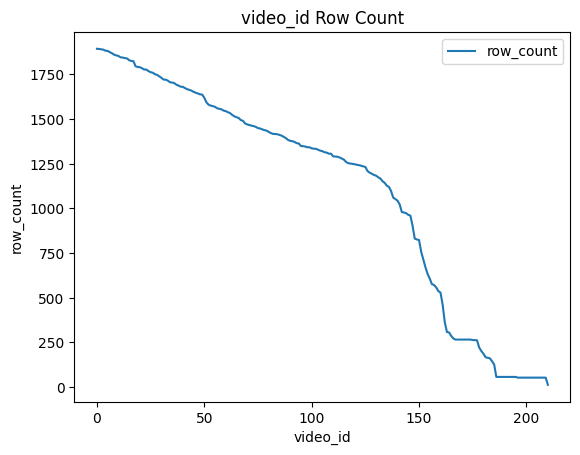

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
video_id_row_count.sort_index().plot(kind = 'line')
plt.title('video_id Row Count')
plt.xlabel('video_id')
plt.ylabel('row_count')
plt.show()

On second thought, create a function to add a flag that indicates if there is continuity in the days.

Purpose: If a video_id has many non-continuous days, would consider to remove from training. If a video_id has a few non-continuous days, to handle these separately. Perhaps impute the missing days based on data of day(s) before and day(s) after?

Code: If 'day' == 'next_day', return True. If 'day' is the latest day for a given video_id, return True. Else, return False.

In [8]:
def check_continuous_day(df):
    df['day'] = pd.to_datetime(df['day'], errors = 'coerce')
    df = df.sort_values(by = ['video_id', 'day'])
    df['next_day'] = df.groupby('video_id')['day'].shift(-1)
    df['continuous_day_flag'] = (df['day'] + pd.Timedelta(days = 1)) == df['next_day']
    latest_day = df.groupby('video_id')['day'].transform('max')
    df['continuous_day_flag'] = (df['continuous_day_flag']) | (df['day'] == latest_day)
    return df

In [9]:
video_id_day = train_data.loc[:, ['video_id', 'day']]
continuous_day_map = check_continuous_day(video_id_day)

In [10]:
continuous_day_map.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234889 entries, 10877 to 234728
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   video_id             234889 non-null  object        
 1   day                  234889 non-null  datetime64[ns]
 2   next_day             234678 non-null  datetime64[ns]
 3   continuous_day_flag  234889 non-null  bool          
dtypes: bool(1), datetime64[ns](2), object(1)
memory usage: 7.4+ MB


Create dataframe containing video_id, and continuous_flag_count (the number of rows in the training data that is continuous in days)

In [11]:
video_id_continuous_day_count = continuous_day_map[['video_id', 'continuous_day_flag']].value_counts().reset_index()
video_id_continuous_day_count.columns = ['video_id', 'continuous_day_flag', 'continuous_flag_count']
video_id_continuous_day_count.head(250)

,video_id,continuous_day_flag,continuous_flag_count
0,YuQaT52VEwo,True,1893
1,SfTEVOQP-Hk,True,1892
2,bN7jBc95XDo,True,1890
3,V1YwVETqB2c,True,1888
4,WRD9aHXC89I,True,1882
...,...,...,...
206,YJblVH2YcpE,True,53
207,9N-WTN4L0p4,True,53
208,8s9Z7JQ1Svg,True,53
209,pWKKxy4xyok,True,53


In [12]:
# Join tables with row_count and continuous_flag_count.
video_id_row_count_continuous_day_count = pd.merge(video_id_row_count, video_id_continuous_day_count, on = 'video_id', how = 'left')
video_id_row_count_continuous_day_count

,video_id,row_count,continuous_day_flag,continuous_flag_count
0,YuQaT52VEwo,1893,True,1893
1,SfTEVOQP-Hk,1892,True,1892
2,bN7jBc95XDo,1890,True,1890
3,V1YwVETqB2c,1888,True,1888
4,WRD9aHXC89I,1882,True,1882
...,...,...,...,...
206,wozpFePfflk,53,True,53
207,2F5RxV5fH1M,53,True,53
208,7wydjX4ZFM0,53,True,53
209,YJblVH2YcpE,53,True,53


In [13]:
matching_count = video_id_row_count_continuous_day_count[video_id_row_count_continuous_day_count['row_count'] == video_id_row_count_continuous_day_count['continuous_flag_count']]['video_id'].nunique()
non_matching_count = video_id_row_count_continuous_day_count[video_id_row_count_continuous_day_count['row_count'] != video_id_row_count_continuous_day_count['continuous_flag_count']]['video_id'].nunique()
matching_count_summary = pd.DataFrame({
    'Condition': ['row_count = continuous_flag_count', 'row_count != continuous_flag_count'],
    'video_id Count': [matching_count, non_matching_count]
})
matching_count_summary

,Condition,video_id Count
0,row_count = continuous_flag_count,211
1,row_count != continuous_flag_count,0


Turns out, all video_id have row_count = continuous_flag_count. Cool.

Some video_ids have 1.8k+ rows of data, while others have only 50+. Now, to determine the cut-off point for video_ids that have low number of rows. Thoughts:
1. Approach: Manually set cut-off point of 100 rows as a start. Those with fewer than 100 rows to be used as test data.
2. (for later) The cut-off point could be a parameter to be fine-tuned.

In [14]:
# Manually set cut-off point at 100
cut_off_point = 100
train_video_id = video_id_row_count_continuous_day_count['video_id'][video_id_row_count_continuous_day_count['row_count'] >= cut_off_point]
test_video_id = video_id_row_count_continuous_day_count['video_id'][video_id_row_count_continuous_day_count['row_count'] < cut_off_point]

train_data_above_cut_off_point = train_data[train_data['video_id'].isin(train_video_id)]
test_data = train_data[train_data['video_id'].isin(test_video_id)]

In [15]:
train_data_above_cut_off_point.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233564 entries, 0 to 234888
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   video_id                        233564 non-null  object 
 1   day                             233564 non-null  object 
 2   views                           233564 non-null  float64
 3   redViews                        233564 non-null  float64
 4   comments                        233564 non-null  float64
 5   likes                           233564 non-null  float64
 6   dislikes                        233564 non-null  float64
 7   videosAddedToPlaylists          233564 non-null  float64
 8   videosRemovedFromPlaylists      233564 non-null  float64
 9   shares                          233564 non-null  float64
 10  estimatedMinutesWatched         233564 non-null  float64
 11  estimatedRedMinutesWatched      233564 non-null  float64
 12  averageViewDuration  

Plotting a line chart to see views, likes, and shares of a random video_id from train_data_above_cut_off_point

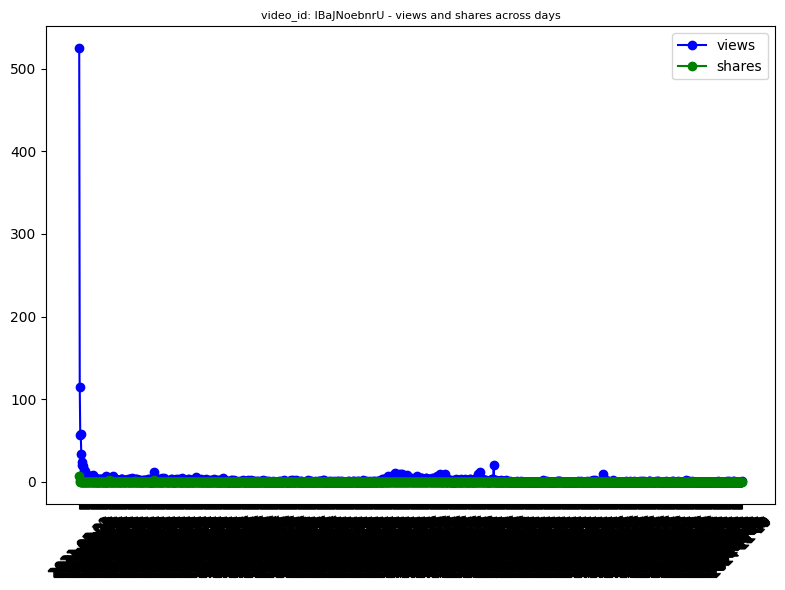

In [16]:
sample_id = train_data_above_cut_off_point['video_id'].sample(n=1).iloc[0]
sample_train_data = train_data_above_cut_off_point[train_data_above_cut_off_point['video_id'] == sample_id].sort_values(by = 'day')
# sample_train_data = sample_train_data.head(len(sample_train_data) // 2)
plt.figure(figsize=(8,6))
plt.plot(sample_train_data['day'], sample_train_data['views'], label='views', color='b', marker='o')
plt.plot(sample_train_data['day'], sample_train_data['shares'], label='shares', color='g', marker='o')
plt.title('video_id: ' + str(sample_id) + ' - views and shares across days', fontsize = 8)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

Before adding some additional columns that may be useful to analyze impact of "Share" on "Views", to also explore correlations between features present in original dataset.

**Approach:** To aggregate the statistics for each video_id's first 100 days (cut_off_point), then look for insights via a correlation matrix.

In [17]:
agg_func1 = 'sum'
agg_func2 = 'mean'
agg_func3 = 'max'
agg_func4 = 'min'
agg_func5 = 'count'
train_data_above_cut_off_sorted = train_data_above_cut_off_point.sort_values(by = ['video_id', 'day'])
train_data_above_cut_off_first_100_days = train_data_above_cut_off_sorted.groupby('video_id').head(cut_off_point)
train_data_agg_first_100_days = train_data_above_cut_off_first_100_days.groupby('video_id').agg({
    'views': [agg_func1, agg_func3, agg_func4],
    'day': agg_func5,
    'redViews': [agg_func1, agg_func3, agg_func4],
    'comments': [agg_func1, agg_func3, agg_func4],
    'likes': agg_func1,
    'dislikes': agg_func1,
    'videosAddedToPlaylists': agg_func1,
    'videosRemovedFromPlaylists': agg_func1,
    'shares': agg_func1,
    'estimatedMinutesWatched': [agg_func1, agg_func2],
    'estimatedRedMinutesWatched': agg_func1,
    'averageViewDuration': agg_func2,
    'averageViewPercentage': agg_func2,
    'annotationClickThroughRate': agg_func2,
    'annotationCloseRate': agg_func2,
    'annotationImpressions': agg_func1,
    'annotationClickableImpressions': agg_func1,
    'annotationClosableImpressions': agg_func1,
    'annotationClicks': agg_func1,
    'annotationCloses': agg_func1,
    'cardClickRate': agg_func2,
    'cardTeaserClickRate': agg_func2,
    'cardImpressions': agg_func1,
    'cardTeaserImpressions': agg_func1,
    'cardClicks': agg_func1,
    'cardTeaserClicks': agg_func1,
    'subscribersGained': agg_func1,
    'subscribersLost': agg_func1
})
train_data_agg_first_100_days.columns = ['_'.join(col).strip() for col in train_data_agg_first_100_days.columns]

In [18]:
train_data_agg_first_100_days.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, -4G1CgJqnHM to zoOl1hw04L0
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   views_sum                           186 non-null    float64
 1   views_max                           186 non-null    float64
 2   views_min                           186 non-null    float64
 3   day_count                           186 non-null    int64  
 4   redViews_sum                        186 non-null    float64
 5   redViews_max                        186 non-null    float64
 6   redViews_min                        186 non-null    float64
 7   comments_sum                        186 non-null    float64
 8   comments_max                        186 non-null    float64
 9   comments_min                        186 non-null    float64
 10  likes_sum                           186 non-null    float64
 11  dislikes_sum                    

In [19]:
# Create a correlation matrix. Method of correlation is the Kendall Tau correlation coefficient (instead of Pearson, which assumes linearity)
corr_matrix = train_data_agg_first_100_days.corr(method = 'kendall')

In [20]:
# Correlation matrix for views_sum
corr_matrix['views_sum'].sort_values(ascending = False)

views_sum                             1.000000
redViews_sum                          0.900093
likes_sum                             0.899774
videosAddedToPlaylists_sum            0.880357
shares_sum                            0.844174
estimatedRedMinutesWatched_sum        0.825195
videosRemovedFromPlaylists_sum        0.824955
subscribersGained_sum                 0.821592
views_min                             0.803216
estimatedMinutesWatched_mean          0.801848
estimatedMinutesWatched_sum           0.801848
comments_sum                          0.795636
dislikes_sum                          0.761447
redViews_min                          0.734871
views_max                             0.732957
redViews_max                          0.690127
comments_max                          0.568132
averageViewDuration_mean              0.535674
subscribersLost_sum                   0.518229
cardTeaserClicks_sum                  0.163321
cardTeaserImpressions_sum             0.160015
cardImpressio

In [21]:
# Correlation matrix for shares_sum
corr_matrix['shares_sum'].sort_values(ascending = False)

shares_sum                            1.000000
videosAddedToPlaylists_sum            0.875986
likes_sum                             0.866662
views_sum                             0.844174
redViews_sum                          0.831121
videosRemovedFromPlaylists_sum        0.824423
subscribersGained_sum                 0.796443
comments_sum                          0.795445
views_min                             0.756933
estimatedRedMinutesWatched_sum        0.749718
views_max                             0.748868
dislikes_sum                          0.735322
estimatedMinutesWatched_mean          0.710013
estimatedMinutesWatched_sum           0.710013
redViews_max                          0.702088
redViews_min                          0.699178
comments_max                          0.596759
subscribersLost_sum                   0.515090
averageViewDuration_mean              0.471537
cardTeaserClicks_sum                  0.156843
cardTeaserClickRate_mean              0.148275
cardTeaserImp

# Analytics approach